In [1]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Interpolate the nectdf file downloaded from Copernicus into ROMS grid

In [2]:
# Read the file with data
with xr.open_dataset('Copernicus.nc') as ds:
        ds = ds      
ds

<xarray.Dataset>
Dimensions:         (lon: 89, time: 762, lat: 56)
Coordinates:
  * lon             (lon) float32 2.975 3.025 3.075 3.125 ... 7.275 7.325 7.375
  * time            (time) datetime64[ns] 2018-12-01T12:00:00 ... 2020-12-31T...
  * lat             (lat) float32 58.47 58.53 58.58 58.62 ... 61.12 61.17 61.22
Data variables:
    analysis_error  (time, lat, lon) float32 ...
    analysed_sst    (time, lat, lon) float32 ...
    mask            (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                                    CF-1.4, ACDD-1.3
    title:                                          Global SST & Sea Ice Anal...
    summary:                                        A merged, multi-sensor L4...
    references:                                     Good S, Fiedler E, Mao C,...
    institution:                                    UKMO
    history:                                        Created from sst.nc; obs_...
    ...                                             ...
    publisher_name:                                 GHRSST Project Office
    publisher_url:                                  http://www.ghrsst.org
    publisher_email:                                ghrsst-po@nceo.ac.uk
    processing_level:                               L4
    cdm_data_type:                                  grid
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

In [3]:
ds.analysed_sst['units'] = 'celcius (converted from kelvins)' #.data - 273.15
ds = ds.assign(analysed_sst_celsius= ds.analysed_sst - 273.15)
ds #.attrs #analysed_sst.units

<xarray.Dataset>
Dimensions:               (lon: 89, time: 762, lat: 56)
Coordinates:
  * lon                   (lon) float32 2.975 3.025 3.075 ... 7.275 7.325 7.375
  * time                  (time) datetime64[ns] 2018-12-01T12:00:00 ... 2020-...
  * lat                   (lat) float32 58.47 58.53 58.58 ... 61.12 61.17 61.22
Data variables:
    analysis_error        (time, lat, lon) float32 ...
    analysed_sst          (time, lat, lon) float32 282.3 282.3 ... 280.0 279.9
    mask                  (time, lat, lon) float32 ...
    analysed_sst_celsius  (time, lat, lon) float32 9.19 9.18 9.17 ... 6.86 6.8
Attributes: (12/48)
    Conventions:                                    CF-1.4, ACDD-1.3
    title:                                          Global SST & Sea Ice Anal...
    summary:                                        A merged, multi-sensor L4...
    references:                                     Good S, Fiedler E, Mao C,...
    institution:                                    UKMO
    history:                                        Created from sst.nc; obs_...
    ...                                             ...
    publisher_name:                                 GHRSST Project Office
    publisher_url:                                  http://www.ghrsst.org
    publisher_email:                                ghrsst-po@nceo.ac.uk
    processing_level:                               L4
    cdm_data_type:                                  grid
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

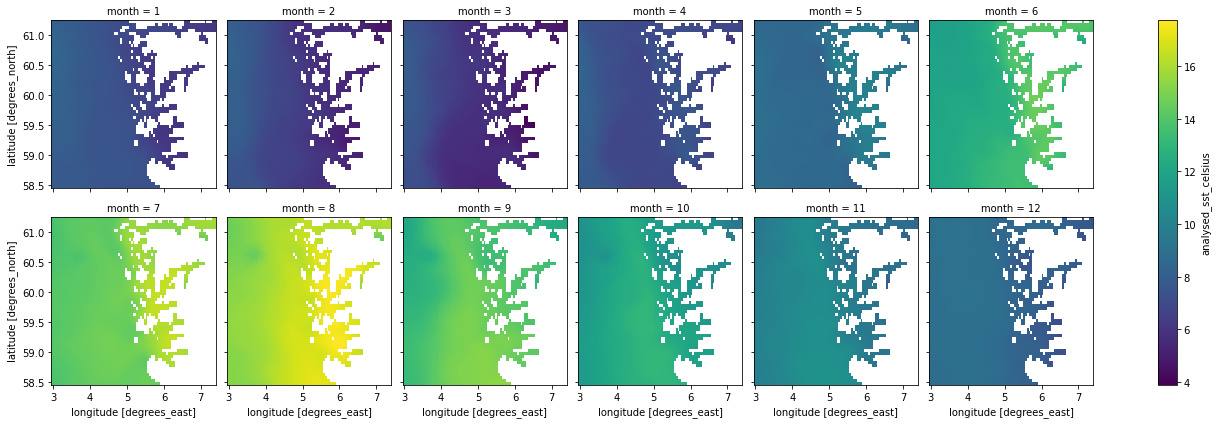

In [4]:
grouped = ds.analysed_sst_celsius.groupby('time.month').mean()
grouped.plot(x="lon", y="lat", col="month", col_wrap=6)

### Plot the old grid against the new grid

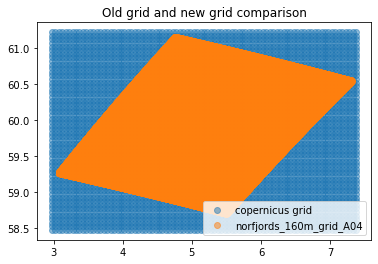

In [5]:
ds_grid = xr.open_dataset('norfjords_160m_grid_A04.nc') #/home/lisapro/OneDrive/Documents/Projects/from Windows/
xv, yv = np.meshgrid(ds.isel(time=10).lon.values, ds.isel(time=0).lat.values)

plt.title('Old grid and new grid comparison')
plt.scatter(xv,yv,alpha = 0.5,label = 'copernicus grid')
plt.scatter(ds_grid.lon_rho.values,ds_grid.lat_rho.values,alpha = 0.5,label =  'norfjords_160m_grid_A04')
plt.legend(loc = 'lower right');

### Create regridder 

In [6]:
ds_out = ds_grid.rename({'lon_rho': 'lon', 'lat_rho': 'lat'})
regridder = xe.Regridder(ds.isel(time = 0), ds_out, 'bilinear')
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_56x89_961x1441.nc 
Reuse pre-computed weights? False 
Input grid shape:           (56, 89) 
Output grid shape:          (961, 1441) 
Periodic in longitude?      False

### Apply regridder separately to analysed sst and analysis_error

In [7]:
ds_out = regridder(ds) #.analysed_sst_celsius

/opt/conda/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [8]:
ds_out

<xarray.Dataset>
Dimensions:               (time: 762, eta_rho: 961, xi_rho: 1441)
Coordinates:
  * time                  (time) datetime64[ns] 2018-12-01T12:00:00 ... 2020-...
    lon                   (eta_rho, xi_rho) float64 5.498 5.499 ... 4.76 4.761
    lat                   (eta_rho, xi_rho) float64 58.7 58.7 ... 61.16 61.16
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    analysis_error        (time, eta_rho, xi_rho) float64 0.7369 0.7384 ... 0.32
    analysed_sst          (time, eta_rho, xi_rho) float64 281.6 281.6 ... 281.7
    mask                  (time, eta_rho, xi_rho) float64 1.0 1.0 ... 1.0 1.0
    analysed_sst_celsius  (time, eta_rho, xi_rho) float64 8.405 8.405 ... 8.546
Attributes:
    regrid_method:  bilinear

In [28]:
ds_out_sst = ds_out.analysed_sst_celsius
ds_out_errors = ds_out.analysis_error

In [29]:
ds_out_sst.to_netcdf('regridded_sst_celsius.nc') #analysed_sst_celsius
ds_out_errors.to_netcdf('regridded_analysis_error.nc') 

In [30]:
ds_out_sst

<xarray.DataArray 'analysed_sst_celsius' (time: 762, eta_rho: 961, xi_rho: 1441)>
array([[[8.40544321, 8.40520681, 8.4049704 , ...,        nan,
                nan,        nan],
        [8.40593885, 8.40570248, 8.40546608, ...,        nan,
                nan,        nan],
        [8.40643452, 8.40619816, 8.40596178, ...,        nan,
                nan,        nan],
        ...,
        [9.08184947, 9.0822883 , 9.08272716, ..., 9.37022315,
         9.36912352, 9.36801064],
        [9.08081968, 9.08125846, 9.08169729, ..., 9.37275269,
         9.37166436, 9.37056279],
        [9.07979015, 9.08022859, 9.08066738, ..., 9.37529546,
         9.37421844, 9.37312818]],

       [[8.28293071, 8.28293786, 8.28293281, ...,        nan,
                nan,        nan],
        [8.28327046, 8.28328749, 8.28329232, ...,        nan,
                nan,        nan],
        [8.28362241, 8.28364931, 8.28366402, ...,        nan,
                nan,        nan],
...
        [8.17287897, 8.172835  , 8.17279101, ..., 8.34573969,
         8.34583457, 8.34592924],
        [8.17225326, 8.17220931, 8.17216533, ..., 8.35104712,
         8.35114221, 8.35123708],
        [8.17172573, 8.17158364, 8.17153968, ..., 8.35635477,
         8.35645006, 8.35654514]],

       [[7.41835665, 7.41831358, 7.41827059, ...,        nan,
                nan,        nan],
        [7.41712014, 7.41707701, 7.41703395, ...,        nan,
                nan,        nan],
        [7.41588355, 7.41584036, 7.41579723, ...,        nan,
                nan,        nan],
        ...,
        [8.72093267, 8.72115208, 8.72137151, ..., 8.55006473,
         8.54711887, 8.54415981],
        [8.72041777, 8.72063717, 8.72085658, ..., 8.55108329,
         8.54814867, 8.54520085],
        [8.71982162, 8.72012223, 8.72034162, ..., 8.55211503,
         8.54919165, 8.54625508]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-12-01T12:00:00 ... 2020-12-31T12:00:00
    lon      (eta_rho, xi_rho) float64 5.498 5.499 5.5 ... 4.758 4.76 4.761
    lat      (eta_rho, xi_rho) float64 58.7 58.7 58.7 ... 61.16 61.16 61.16
Dimensions without coordinates: eta_rho, xi_rho

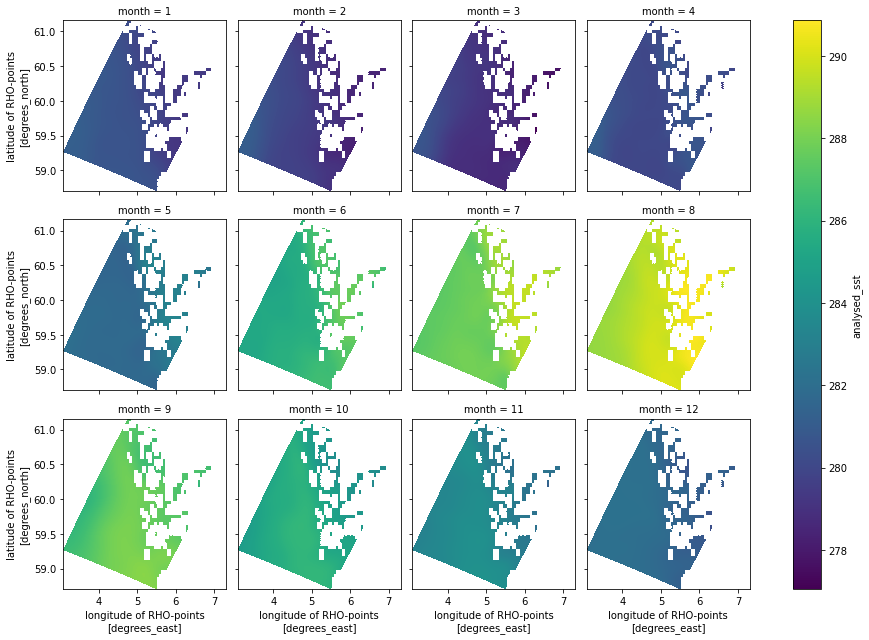

In [11]:
grouped_regridded_sst = ds_out_sst.groupby('time.month').mean()
grouped_regridded_sst.plot(x="lon", y="lat", col="month", col_wrap=4);

In [12]:
#TODO: Create another regridder for ssh, regrid and save 

In [24]:
# Read the file with data
with xr.open_dataset('SSH_Copernicus.nc',engine = "netcdf4") as ds:
    ds_ssh = ds  
#from netCDF4 import Dataset
#rootgrp = Dataset(r'SSH_Copernicus.nc')
#rootgrp

OSError: [Errno -101] NetCDF: HDF error: b'/home/jovyan/oceanography/romstools/CreateObsFileIS4DVAR/SSH_Copernicus.nc'